In [2]:
# colab не может найти зависимость
# !pip install accelerate

In [4]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations as A
import numpy as np
import torch

from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
# from dataset import CustomVOCSegmentation
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

from helpy import visualize_samples, rename_files_in_folder, rename_files_and_update_annotations
from CustomCOCOSegmentation import CustomCOCOSegmentation
from train import (
    CheckpointSaver,
    IoUMetric,
    MulticlassCrossEntropyLoss,
    MulticlassDiceLoss,
    load_checkpoint,
    train
)
from UnetBackbone import UNet, count_model_params

In [5]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

In [6]:
# rename_files_and_update_annotations("dataset/images/train")
# rename_files_and_update_annotations("dataset/images/valid")

train_00000.jpg -> train_00000.jpg
train_00001.jpg -> train_00001.jpg
train_00002.jpg -> train_00002.jpg
train_00003.jpg -> train_00003.jpg
train_00004.jpg -> train_00004.jpg
train_00005.jpg -> train_00005.jpg
train_00006.jpg -> train_00006.jpg
train_00007.jpg -> train_00007.jpg
train_00008.jpg -> train_00008.jpg
train_00009.jpg -> train_00009.jpg
train_00010.jpg -> train_00010.jpg
train_00011.jpg -> train_00011.jpg
train_00012.jpg -> train_00012.jpg
train_00013.jpg -> train_00013.jpg
train_00014.jpg -> train_00014.jpg
train_00015.jpg -> train_00015.jpg
train_00016.jpg -> train_00016.jpg
train_00017.jpg -> train_00017.jpg
train_00018.jpg -> train_00018.jpg
train_00019.jpg -> train_00019.jpg
train_00020.jpg -> train_00020.jpg
train_00021.jpg -> train_00021.jpg
train_00022.jpg -> train_00022.jpg
train_00023.jpg -> train_00023.jpg
train_00024.jpg -> train_00024.jpg
train_00025.jpg -> train_00025.jpg
train_00026.jpg -> train_00026.jpg
train_00027.jpg -> train_00027.jpg
train_00028.jpg -> t

In [7]:
# Определяем размер изображения
IMAGE_SIZE = 512  # Или любой другой размер

# Группировка базовых преобразований
basic_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),  # Изменение размера
    A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, p=1.0),  # Добавление паддинга
    A.CropNonEmptyMaskIfExists(height=IMAGE_SIZE, width=IMAGE_SIZE),  # Обрезка
    A.HorizontalFlip(p=0.5),  # Случайный горизонтальный флип
])

# Группировка агрессивных преобразований
aggressive_transforms = A.Compose([
    A.OneOf([
        A.AdvancedBlur(p=0.5),  # Размытие
        A.GaussNoise(p=0.5),  # Шум Гаусса
        A.CLAHE(p=0.5),  # CLAHE
    ], p=0.5),  # Применяется с вероятностью 30%
    
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),  # Случайная яркость и контраст
        A.RandomGamma(p=0.5),  # Случайная гамма
        A.ColorJitter(p=0.5),  # Случайное изменение яркости, контраста и насыщенности
    ], p=0.5),  # Применяется с вероятностью 30%
    
    A.Rotate(limit=20, p=0.5),  # Случайный поворот
])

# Итоговая трансформация, где сначала применяются базовые, затем агрессивные
transforms = A.Compose([
    basic_transforms,  # Базовые преобразования
    aggressive_transforms,  # Агрессивные преобразования
    ToTensorV2(),  # Преобразование в тензор
])

In [8]:
train_dataset = CustomCOCOSegmentation(
    root_dir="dataset/images/train",
    ann_file="dataset/images/train/annotations.json",
    transform=transforms
)

val_dataset = CustomCOCOSegmentation(
    root_dir="dataset/images/valid",
    ann_file="dataset/images/valid/annotations.json",
    transform=transforms
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Визуализируем изображение и маску

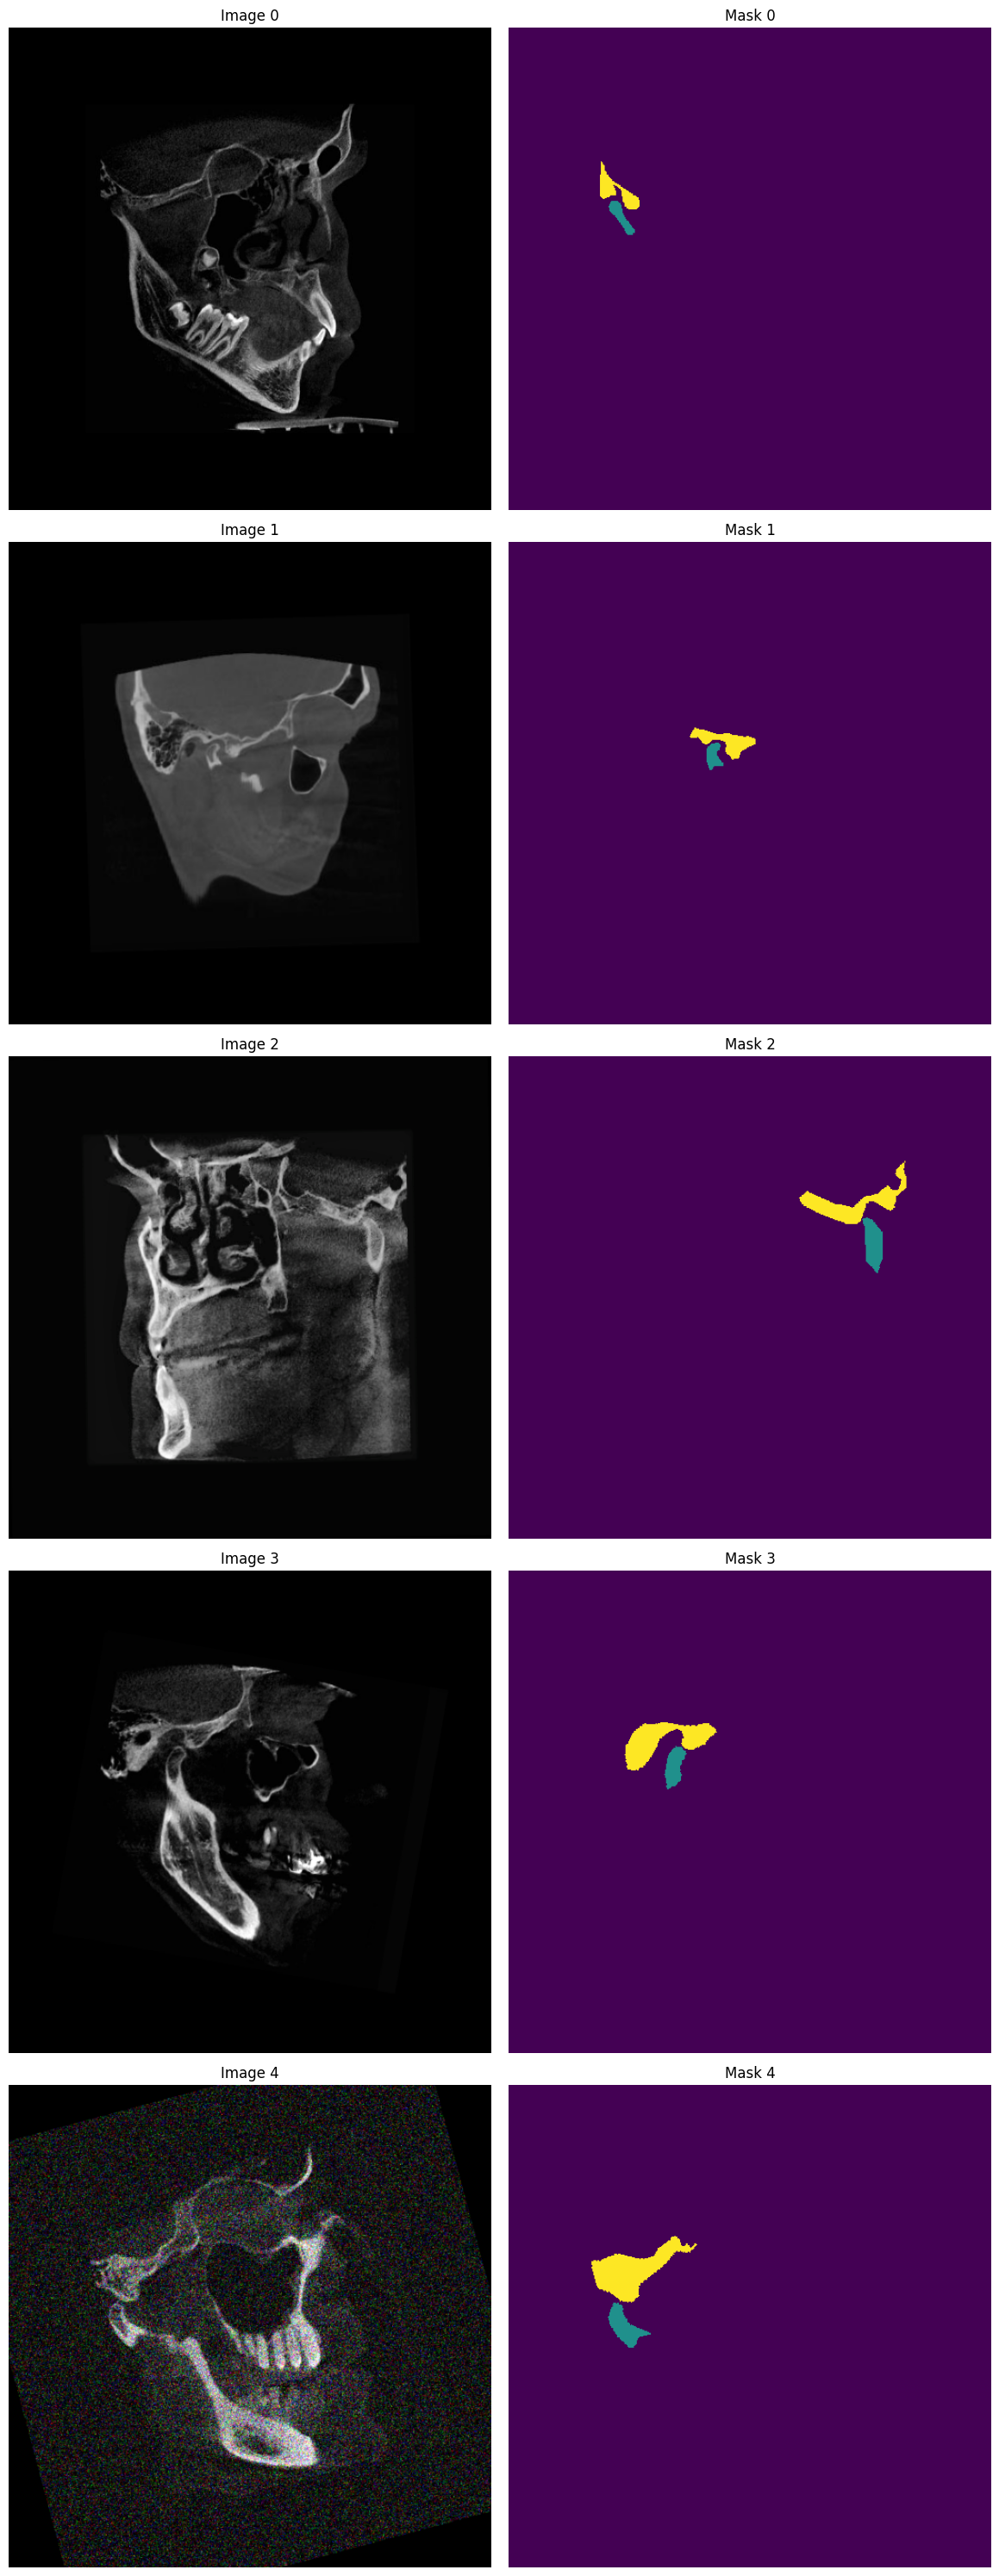

In [9]:
# Пример вызова функции с диапазоном индексов от 0 до 10
visualize_samples(train_dataset, range(0, 5))

## Обучение модели

In [10]:
CLASSES_NUM = 2

BACKBONE_NAME = "resnet50"

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BETAS = (0.9, 0.999)
BATCH_SIZE = 4
NUM_WORKERS = 4
EPOCH_NUM = 75
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

accelerator = Accelerator(cpu=False, mixed_precision="fp16")
model = UNet(backbone_name=BACKBONE_NAME, classes_num=CLASSES_NUM)

loss_fn = MulticlassCrossEntropyLoss(ignore_index=255, reduction="sum")
metric_fn = IoUMetric(classes_num=CLASSES_NUM, reduction="macro")

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=10, gamma=0.85
)

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="mIoU",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)

/Users/dmitry/Developer/PycharmProjects/TMJ/.venv/lib/python3.12/site-packages/accelerate/accelerator.py:469: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/Users/dmitry/Developer/PycharmProjects/TMJ/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/dmitry/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

In [ ]:
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [ ]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

In [ ]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
    show_every_x_batch=15,
)